In [139]:
from patsy import dmatrix
import statsmodels.api as sm
import pandas as pd
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures



In [2]:
try:
    from utils import split_data, load_data, DATA_PATH, inverse_transform
except ImportError:  # notebook being ran in child dir
    import sys; sys.path.insert(0, '..')  # add parent to path
    from utils import split_data, load_data, DATA_PATH, inverse_transform

In [3]:
df = load_data(DATA_PATH)

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2041 entries, 0 to 2040
Data columns (total 28 columns):
 #   Column                         Non-Null Count  Dtype         
---  ------                         --------------  -----         
 0   Unnamed: 0                     2041 non-null   int64         
 1   Date                           2041 non-null   datetime64[ns]
 2   Site                           2041 non-null   object        
 3   Staff Reported Positive Tests  2041 non-null   int64         
 4   # of Currently Positive Staff  2041 non-null   int64         
 5    Staff Deaths                  2041 non-null   int64         
 6   Staff Recovered                2041 non-null   int64         
 7   Housing type                   2041 non-null   object        
 8   Isolation Inmates              2041 non-null   int64         
 9   Positive Inmates               2041 non-null   int64         
 10  Confirmed Inmate Deaths        2041 non-null   int64         
 11  Pending Results  

In [5]:
df.columns

Index(['Unnamed: 0', 'Date', 'Site', 'Staff Reported Positive Tests',
       '# of Currently Positive Staff', ' Staff Deaths', 'Staff Recovered',
       'Housing type', 'Isolation Inmates', 'Positive Inmates',
       'Confirmed Inmate Deaths', 'Pending Results', 'Recovered Inmates',
       'Daily Recovered', 'N1', 'N2', 'B.1.1.7 (Alpha)', 'B.1.351 (Beta)',
       'P.1 (Gamma)', 'B.1.617 (Delta)', 'B.1.427/B.1.429 (Epsilon)',
       'N679K/Q954H (Omicron)', 'Presumptive Cases',
       'Average Presumptive Cases', 'Y', 'X', 'housing_factor', 'site_factor'],
      dtype='object')

In [6]:
df["N_avg"] = (df.N1 + df.N2) / 2

In [119]:
q75, q25 = np.nanpercentile(df["N_avg"], [75 ,25])
iqr = q75 - q25

In [121]:
strong_outliers = q75 + 3 * iqr

In [135]:
df.dropna(subset=[x_col, y_col]).shape

(2038, 29)

In [134]:
df.shape[0]

2041

In [137]:
df_.shape

(1831, 29)

In [130]:
df_.loc[df.N_avg < strong_outliers].shape

(1735, 29)

In [133]:
df["# of Currently Positive Staff"].isna().sum()

0

In [ ]:
df.loc[df.N_avg < 150]

In [145]:
x_col = "# of Currently Positive Staff"
y_col = "N_avg"
df_ = df.dropna(subset=[x_col, y_col]).copy()
df_ = df_.loc[df_.N_avg < 50000]
X = df_[[x_col]]
y = df_[[y_col]]

X_train, X_test, y_train, y_test = split_data(X, y)



X_train_detransformed = pd.DataFrame({x_col: inverse_transform(X_train, X).reshape(-1)})
X_test_detransformed = pd.DataFrame({x_col: inverse_transform(X_test, X).reshape(-1)})

y_train_detransformed = pd.DataFrame({y_col: inverse_transform(y_train, y).reshape(-1)})
y_test_detransformed = pd.DataFrame({y_col: inverse_transform(y_test, y).reshape(-1)})

0.0596497842981808
               model  rmse_train  rmse_test
0  Linear Model (lm)     1.01244   0.793901


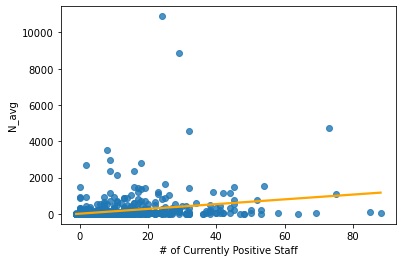

In [146]:
lm = LinearRegression()
lm.fit(X_train, y_train)

# Training data
pred_train = lm.predict(X_train)
rmse_train = mean_squared_error(y_train, pred_train, squared=False)

# Test data
pred_test = lm.predict(X_test)
rmse_test =mean_squared_error(y_test, pred_test, squared=False)


# Save model results
model_results_lm = pd.DataFrame(
    {
    "model": "Linear Model (lm)",  
    "rmse_train": [rmse_train], 
    "rmse_test": [rmse_test],
    })
print(model_results_lm)

sns.regplot(x=X_train_detransformed[x_col], 
            y=y_train_detransformed[y_col],
            ci=None, 
            line_kws={"color": "orange"});

0.06092933057170846
                   model  rmse_train  rmse_test
0  Polynomial Model (pm)    1.010957    0.79336


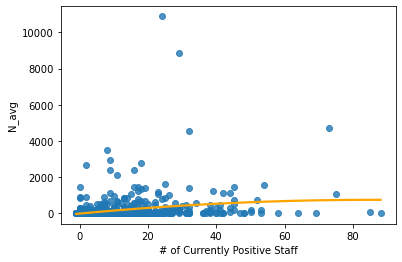

In [147]:

# polynomial degree 2
poly = PolynomialFeatures(2)

X_train_poly = poly.fit_transform(X_train)
X_test_poly = poly.fit_transform(X_test)


pm = LinearRegression()
pm.fit(X_train_poly,y_train)


# Training data
pred_train = pm.predict(X_train_poly)
rmse_train = mean_squared_error(y_train, 
                                pred_train, 
                                squared=False)

# Test data
pred_test = pm.predict(X_test_poly)
rmse_test =mean_squared_error(y_test, 
                              pred_test, 
                              squared=False)


# Save model results
model_results_pm = pd.DataFrame(
    {
    "model": "Polynomial Model (pm)",  
    "rmse_train": [rmse_train], 
    "rmse_test": [rmse_test],
    })

print(model_results_pm)

# plot
sns.regplot(x=X_train_detransformed[x_col], 
            y=y_train_detransformed[y_col],
            ci=None, 
            order=2, 
            line_kws={"color": "orange"});

In [148]:


knots="2, 4, 6"
transformed_x = dmatrix(
            f"bs(train, knots=({knots}), degree=3, include_intercept=False)", 
                {"train": X_train},return_type='dataframe')

cs = sm.GLM(y_train, transformed_x).fit()

-0.00014320536567069553
               model  rmse_train  rmse_test
0  Cubic spline (cs)     0.99596   0.818752


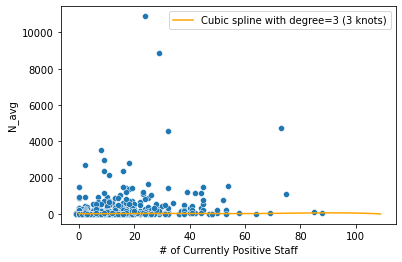

In [150]:

# Generating cubic spline with 3 knots at 10,20,30
transformed_x = dmatrix(
            f"bs(train, knots=({knots}), degree=3, include_intercept=False)", 
                {"train": X_train},return_type='dataframe')

cs = sm.GLM(y_train, transformed_x).fit()


# Training data
pred_train = cs.predict(dmatrix(f"bs(train, knots=({knots}), include_intercept=False)", {"train": X_train}, return_type='dataframe'))
rmse_train = mean_squared_error(y_train, pred_train, squared=False)

# Test data
pred_test = cs.predict(dmatrix(f"bs(test, knots=({knots}), include_intercept=False)", {"test": X_test}, return_type='dataframe'))
rmse_test =mean_squared_error(y_test, pred_test, squared=False)


# Save model results
model_results_cs = pd.DataFrame(
    {
    "model": "Cubic spline (cs)",  
    "rmse_train": [rmse_train], 
    "rmse_test": [rmse_test]
    })

print(model_results_cs)



# Create observations
xp = np.linspace(X_test.min(),X_test.max(), 100)
xp_detransformed = inverse_transform(xp.reshape(-1, 1), X)
# Make some predictions
pred = cs.predict(dmatrix(f"bs(xp, knots=({knots}), include_intercept=False)", {"xp": xp}, return_type='dataframe'))
pred = inverse_transform(pred.to_frame(), X)
# plot
sns.scatterplot(x=X_train_detransformed[x_col], 
            y=y_train_detransformed[y_col],)

plt.plot(xp_detransformed, pred, label='Cubic spline with degree=3 (3 knots)', color='orange')
plt.legend();

0.0628923378733669
                        model  rmse_train  rmse_test
0  Natural cubic spline (ncs)    0.882279   1.063142


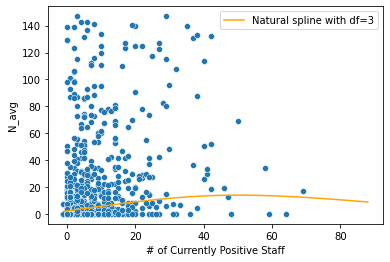

In [144]:

transformed_x3 = dmatrix("cr(train,df = 3)", {"train": X_train}, return_type='dataframe')

ncs = sm.GLM(y_train, transformed_x3).fit()

# Training data
pred_train = ncs.predict(dmatrix("cr(train, df=3)", {"train": X_train}, return_type='dataframe'))
rmse_train = mean_squared_error(y_train, pred_train, squared=False)

# Test data
pred_test = ncs.predict(dmatrix("cr(test, df=3)", {"test": X_test}, return_type='dataframe'))
rmse_test =mean_squared_error(y_test, pred_test, squared=False)

# Save model results
model_results_ncs = pd.DataFrame(
    {
    "model": "Natural cubic spline (ncs)",  
    "rmse_train": [rmse_train], 
    "rmse_test": [rmse_test]
    })

print(model_results_ncs)

# Make predictions
pred = ncs.predict(dmatrix("cr(xp, df=3)", {"xp": xp}, return_type='dataframe'))
pred = inverse_transform(pred.to_frame(), X)
# plot
sns.scatterplot(x=X_train_detransformed[x_col], 
            y=y_train_detransformed[y_col],)
plt.plot(xp_detransformed, pred, color='orange', label='Natural spline with df=3')
plt.legend();

In [101]:
results = pd.DataFrame(columns=["model", "rmse_train", "rmse_test"])
results = pd.concat([results, model_results_lm, model_results_pm, model_results_cs, model_results_ncs], axis=0)

print(results)

                        model  rmse_train  rmse_test
0           Linear Model (lm)    1.012440   0.793901
0       Polynomial Model (pm)    1.010957   0.793360
0           Cubic spline (cs)    0.995960   0.818752
0  Natural cubic spline (ncs)    1.010676   0.804577
